## Objective:
- visualize the data retrieve from OpenDAP server
- using customized function

In [1]:
import numpy as np
import pandas as pd

In [2]:
## libraries for data access and pre-processing
## preprocessing: retireve data from netCDF and convert to pandas columns
import netCDF4 # packages to open 'netcdf' file
import numpy as np # numpy and pandas packages to pre-process the dataset
import pandas as pd

## to load webcontent and retrieve data from link
from IPython.display import display, HTML
from IPython import display
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## CLEANING
import gc
import sys

from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

### Custom functions
- Call the customized functions to pre-process, visualization of the data retrieved from OpenDAP server
1. basemap function -> for ploting visualizatin
2. geopy functino -> Provide geo information on location passed
3. get Session Token -> retrieve session token for getting acces to OpenDAP server
4. webscrap the contents for retrieving multiple files
5. Get patches from vertices-> creates polygon shaped 

In [3]:
from functions_plot.basemap_fun import plot_vertices #1
from functions_plot.geopy_func import get_location #2
from functions_plot.get_session import get_session, open_url #3
from functions_plot.webscrap_files_contents import get_total_files #4
from functions_plot.patches_matplot import get_patches

from functions_plot.memory_usage import get_memory_usage ## To check the memory usage of the script

### NOTE:
1. First, retrieve the contents from the specified year, version of files
2. Get the first file from the list

### Data Source:
- For this tutorial, we will download files from OpenDAP server
- main_url= https://oco2.gesdisc.eosdis.nasa.gov/opendap

#### OCO format
- `OCO2_L2_Lite_FP` -> 10.vr, 11.vr
- `OCO3_L2_Lite_FP` -> 10.vr

**********************************************************

## INPUT Data:
- Information:
    * year and month
- `netCDF` file format on OpenDap Server

**********************************************************
* EXAMPLE:
    - /OCO3_L2_Lite_FP.10.4r
    - /2020
    - <b>FORMAT</b>: /oco3_LtCO2_200106_B10400Br_220317235330s.nc4.html

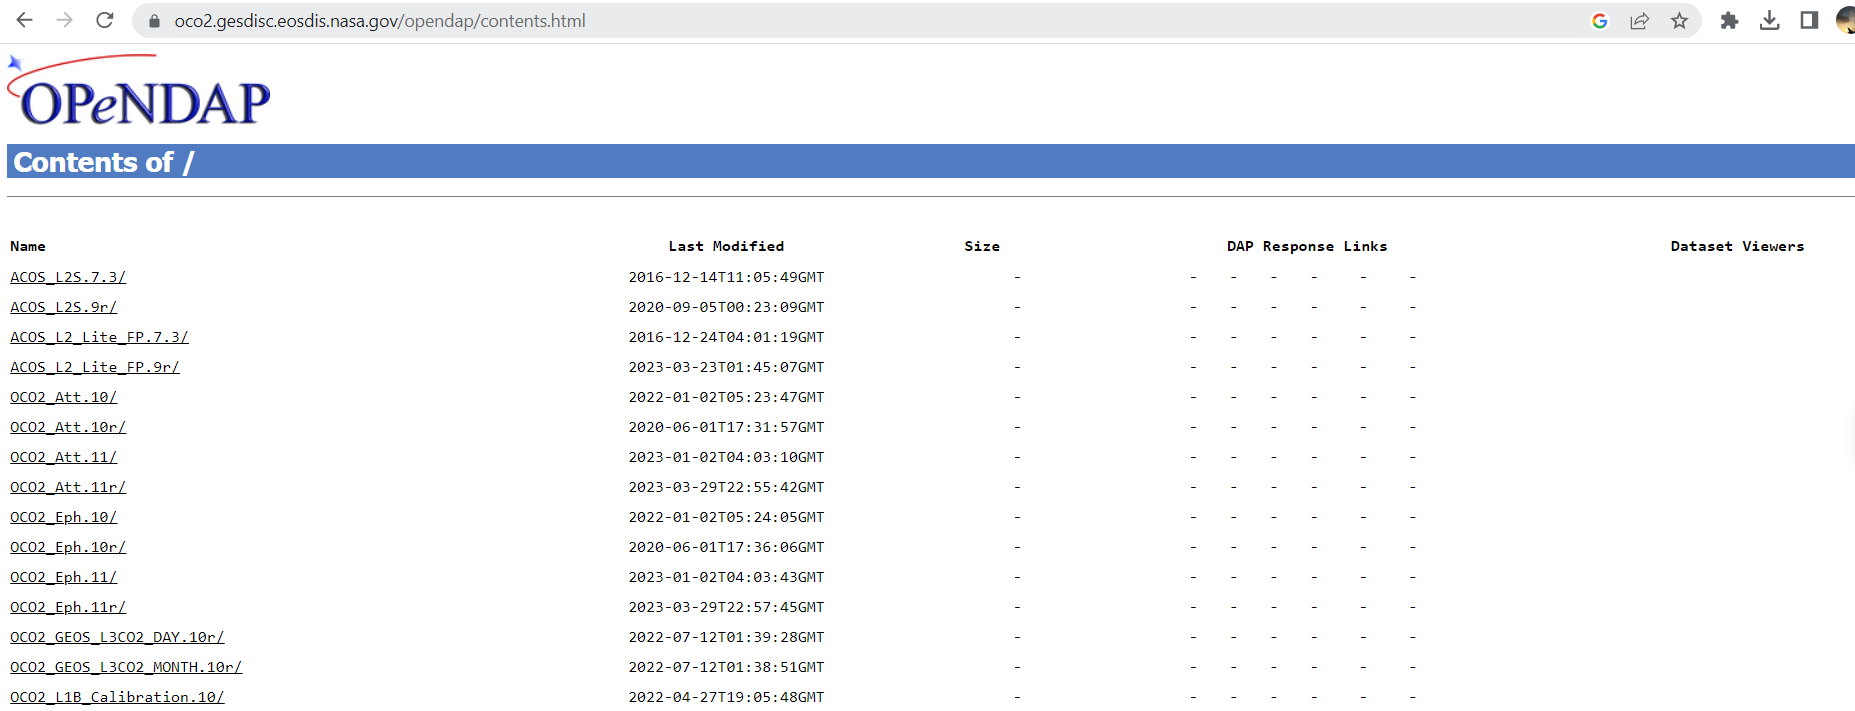

In [4]:
display.Image(filename="../screenshots/opendap_server.png")

In [5]:
%%time
print("OCO3 currently has -> 10 vr.\n")
## INPUT for specified year, version of file
year= input("Enter the Year: ")
month= input("Enter the Month: ")
ver_= input("Enter the version: ")

## FORMAT the filenames by VERSION and YEAR
## RETRIEVE all filenames for the YEAR using webscraping 
lite_file= '/OCO3_L2_Lite_FP.'+ str(ver_)+ '.4r' +'/'+ year

OCO3 currently has -> 10 vr.

Enter the Year: 2022
Enter the Month: 11
Enter the version: 10
Wall time: 5.69 s


In [6]:
########################################################################
# GET THE files from OpenDap source. Open the netcdf file and store in dataframe
# Beautiful soup to retrieve all data for the MONTH
# EXAMPLE: in this test, we will use SINGLE file of the month
########################################################################

main_url='https://oco2.gesdisc.eosdis.nasa.gov/opendap'
content= '/contents.html'

total_files= get_total_files(main_url, lite_file, ver_, year)

### work behind the code:
1. User passing EarthData credentials to openDap server
2. Verify the credentials and retrieve Session Token
3. Retrieve data iteratively using the session token

### Example: single file from the list

In [7]:
total_files[0]

'/OCO3_L2_Lite_FP.10.4r/2022/oco3_LtCO2_220101_B10400Br_220425125219s.nc4'

### Get the Session TOKEN using the customized function
- Pass the webcontent from the retrieved files, TEST 

In [8]:
session= get_session(main_url, total_files[0])

if session:
    print("Status: 200 OK!!")
else:
    print("Session not open. Please try again")


*******************************************

Please provide your Earthdata Login credentials to allow data access

Your credentials will only be passed to https://oco2.gesdisc.eosdis.nasa.gov/opendap and will not be exposed in Jupyter


Username: sagarlimbu
········

*******************************************

Status: 200 OK!!


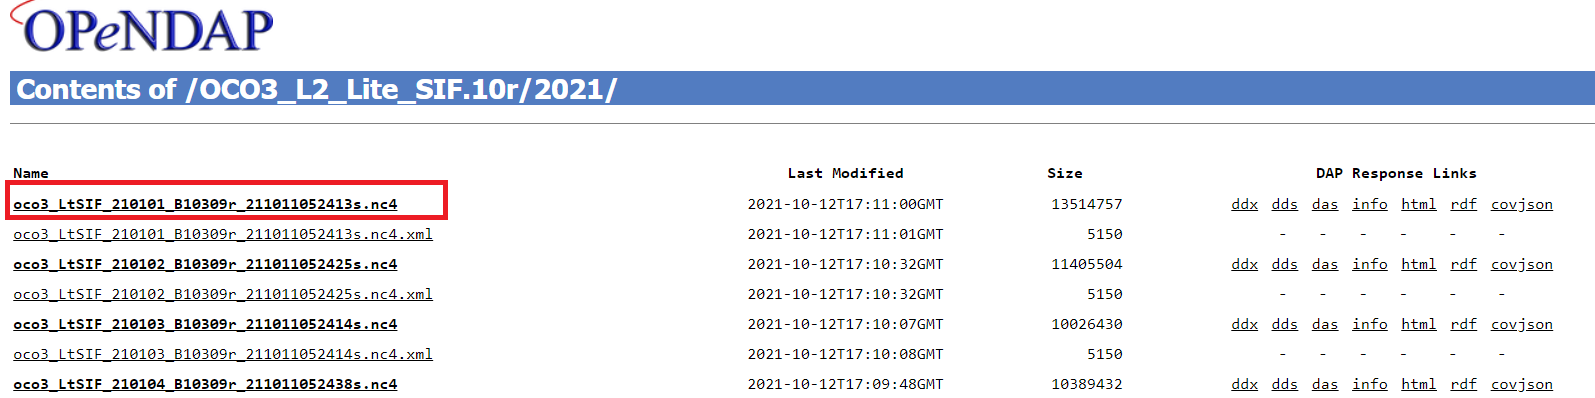

In [9]:
display.Image(filename="../screenshots/opendap_b.png")

### Retrieve files for single month
- For example: we will demonstrate with 15 day cycle period

In [10]:
total_= [f for f in total_files if f.startswith(total_files[0][:41] + month) ]

### EG: 15 day cycle period

In [11]:
total_= total_[:15]
len(total_)

15

### Following function;
- Performs iterative process to access and retrieve multiple files
- Using the same SESSION token generated from previous request to `OPENDAP` website

### Data Access to Multiple files
- takes in pydap data and appends all the variables together

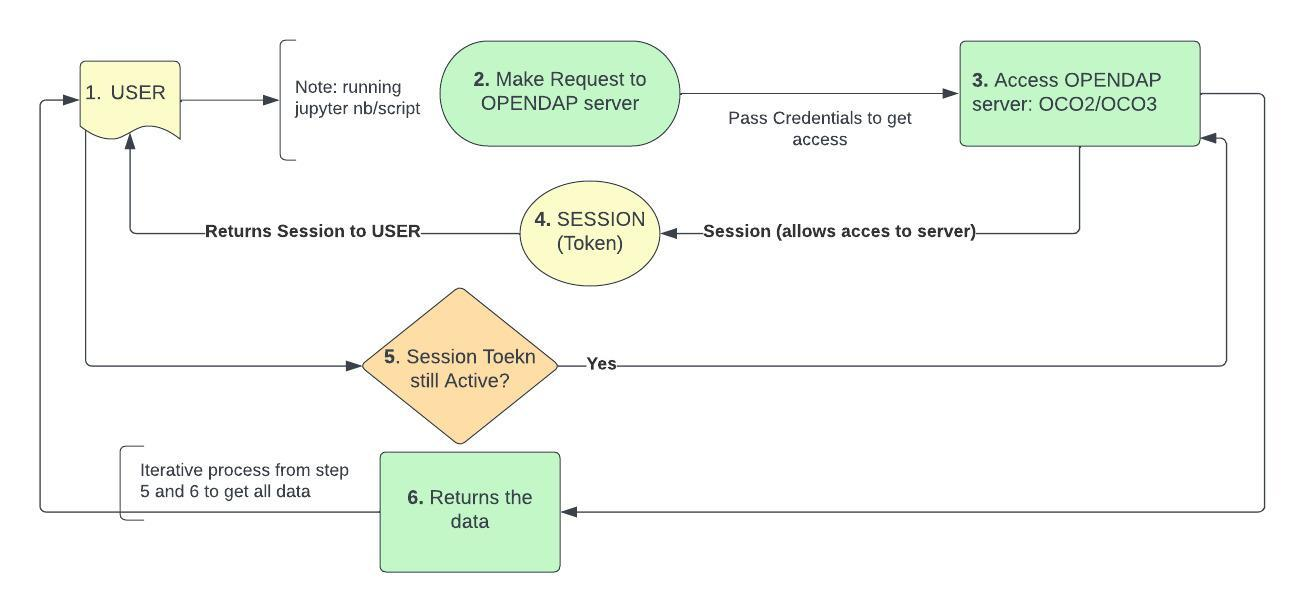

In [12]:
display.Image(filename="../screenshots/pydap_access_session.jpeg",
             width= 900, height= 700)

In [13]:
%%time
# session.post

## list of pydap variables
xco2=[]
long_vertices=[]
lat_vertices=[]
sounding_id=[]
qual_flag=[]

if session:
#     print("alive")
    for j in range(0, len(total_)):
        pydap_df= open_url(main_url + total_[j], session=session)
        print("Retrieving Data object from openDap Server: ")
        print(pydap_df.attributes.keys)
        
        #################################################
        # collect the data
        xco2.append(np.array(pydap_df["xco2"][:]))
        long_vertices.append(pydap_df["vertex_longitude"][:])
        lat_vertices.append(pydap_df["vertex_latitude"][:])
        qual_flag.append(pydap_df["xco2_quality_flag"][:])
#        sounding_id.append(pydap_df["date"])        

        print('***********************/n')
else:
    print("request new ssion")

Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B743F3AFC0>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B743F990C0>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B7440183C0>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B743F4FE00>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B74412A880>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B74412E900>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object at 0x000001B744018AC0>
***********************/n
Retrieving Data object from openDap Server: 
<built-in method keys of dict object a

In [14]:
%%time
##################################################
# 1. Create pandas dataframe to filter the values
def create_pd(xco2, long_vertices, lat_vertices, qual_flag):
    df= pd.DataFrame()
    df["Xco2"]= np.array(np.concatenate(xco2)).ravel() 
    df["Longitude_vertices"]= list(np.array(np.concatenate(long_vertices)))
    df["Latitude_vertices"]= list(np.array(np.concatenate(lat_vertices)))
    df["quality_flag"]= np.array(np.concatenate(qual_flag)).ravel()
    
    ##################################################
    ## Filter the DATA by quality flag-> 0
    df= df[df["quality_flag"]== 0]
    df=df.reset_index()
    df= df.drop(columns=["index"])

    return df

Wall time: 0 ns


## Pre-process the data:
1. Get the required data for plotting
    a. Get patches for ploting polygon shaped vertices: vertex latitude and vertex longitude
    b. Total XCO2 values

In [15]:
#######################
### Get the dataFrame
df_oco3= create_pd(xco2, long_vertices, lat_vertices, qual_flag)

## CLEAN the resource
del xco2
del long_vertices
del lat_vertices
del qual_flag

#########################
## XCO2 values
xco2_total= df_oco3["Xco2"][:]
################################
# NOTE: Generates Polygon shape feature which will be used to plot in the MAP
# use the function to get PATCHES from the Dataframe
patches_total= get_patches(df_oco3)

## Garbage Collect, release memory
del df_oco3
gc.collect()

print("Memory usage, Freeing memory: \n")
get_memory_usage()

Memory usage, Freeing memory: 



,Size
__builtins__,9.09KB
__file__,315.00B
__cached__,161.00B
obj_size_fmt,136.00B
memory_usage,136.00B
get_memory_usage,136.00B
__name__,76.00B
sys,72.00B
pd,72.00B
__package__,63.00B


# Enter the location

In [ ]:
%matplotlib notebook

Enter the Location: los angeles

************************************

Bbox information of :
los angeles


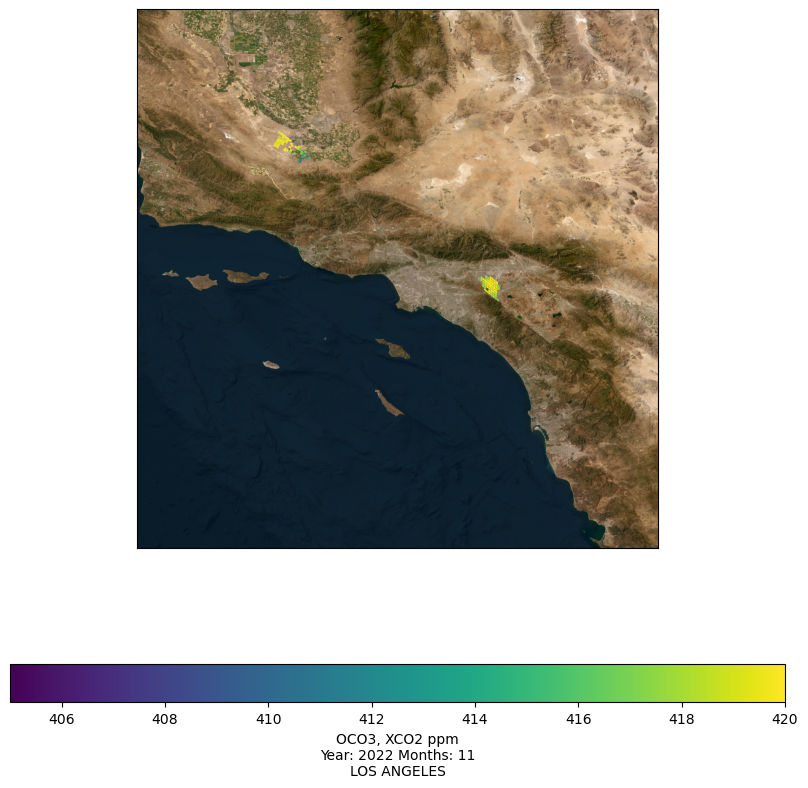

In [16]:
loc= input("Enter the Location: ")

# retrieve the geo information
bbx_list= get_location(loc)

# plot the location
plot_vertices(xco2_total, patches_total, bbx_list, loc, year, month)